In [1]:
#%matplotlib qt5
#%matplotlib inline
#para hacer el grafico animado
%matplotlib notebook  

import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bokeh.plotting as bkplt
import bokeh.models as bkmdls
import bokeh.io as bkio

import matplotlib.cm as cm

from sklearn import cluster,datasets
from mpl_toolkits.mplot3d import Axes3D


from itertools import cycle
from cycler import cycler
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import mixture

from scipy import stats


import matplotlib.colors as colors
import seaborn as sns; sns.set()

import time

import ipynb.fs.defs.my_funcs_clusters as myfunc


In [2]:
rutaxls = 'C:/Users/mungu/Documents/DatosWTG.xlsx'
rutaxlsCPot = 'C:/Users/mungu/Dropbox/Doctorado/Python/aero/Curva de potencia vestas 90.xlsx'
#rutaxls = 'C:/Users/mungu/Documents/DatosWTG.xlsx'
#rutaxlsCPot = 'Curva de potencia vestas 90.xlsx'

dataVPxls = pd.read_excel(rutaxls,usecols=[0,1,2],index_col=0,names=['PCTimeStamp','vViento','Pacw'])
dfCPot = pd.read_excel(rutaxlsCPot,usecols=[0,2],index_col=0,names=['vel','pw'])

#marcando los datos faltantes asignando un nan a la fila completa
datamk = dataVPxls
datamk.loc[datamk.isnull().any(axis=1), :] = np.nan

#eliminando filas con NaN. Si busco la fecha anterior debe aparecer error.
cleanData = datamk.dropna()

###calculando la potencia
#la pontencia del archivo de excel es la densidad de potencia acumulada.
#Se tiene que hacer la resta de la potencia siguiente a la anterio y multiplicar por pi*r^2
#el radio es 45m
#si se hace la resta con un array de numpy (values) si se puede restar 
#pues se hace elemento por elemento
dataVP = cleanData.drop('Pacw',axis=1)
dataVP['Pw']= (cleanData.iloc[1:,1].values-cleanData.iloc[0:-1,1]) * np.pi*45**2

#eliminar el ultimo valor pues es NaN
dataVP.drop(dataVP.tail(1).index,inplace=True) 

#Eliminando outliers
dataVP.drop([pd.to_datetime('2016-03-07 09:50:00')],inplace=True)

#leyendo la direccion del viento
dataDirVxls = pd.read_excel(rutaxls,sheet_name=1, usecols=[0,1],index_col=0,names=['PCTimeStamp','Dir'])
#limpiando datos
#marcando los datos faltantes asignando un nan a la fila completa
datamkdir = dataDirVxls
datamkdir.loc[datamkdir.isnull().any(axis=1), :] = np.nan
#eliminando filas con NaN. Si busco la fecha anterior debe aparecer error.
#tambien elimino el ultimo valor como lo hice en los datos de v y p
#el copy es para que no me de la copy warning
dataDir = datamkdir.dropna().copy()
dataDir.drop(dataDir.tail(1).index,inplace=True) 
#eliminando del outlier de viento misma fecha que el de la pontencia
dataDir.drop([pd.to_datetime('2016-03-07 09:50:00')],inplace=True)

direcvrad= np.deg2rad(dataDir['Dir'].values)
velocidades = dataVP.iloc[:]['vViento'].values
vecVel = [-np.sin(direcvrad)*velocidades,np.cos(direcvrad)*velocidades]
vecVelnp=np.array(vecVel).transpose()
#original sin timestamp
#dfVecVel = pd.DataFrame(data=vecVelnp,columns=['vx','vy']
#con timestamp
dfVecVel = pd.DataFrame(data=vecVelnp,columns=['vx','vy'],index=dataVP.index)

In [3]:
n_clusters= 25
# forzar n  clusters|
model_kmeans = KMeans( n_clusters=n_clusters)
model_kmeans.fit(dfVecVel.values) 
kmeans_labels = model_kmeans.labels_
centroids = model_kmeans.cluster_centers_#los centroides siguen siendo 46
n_clusters = np.unique(kmeans_labels).size

In [4]:
centroids

array([[-7.07151005, 13.33898698],
       [-0.24600755,  0.48613851],
       [-0.59637117,  5.65937545],
       [ 0.27126801, -3.94555055],
       [-3.14861398,  8.10702557],
       [-2.84045776,  0.51845196],
       [-7.36944026, 18.79994832],
       [-6.44074325,  7.82526668],
       [ 2.6008525 , -4.65007959],
       [-1.49118727, -1.90454839],
       [-1.47584109,  2.18287325],
       [-4.03504119, 10.55378345],
       [ 3.58699537, -1.39354902],
       [-6.25669954, 10.91364883],
       [ 1.77446448,  1.01284851],
       [-9.36062548, 11.29848542],
       [-5.95096383, 16.18625269],
       [-9.0407267 , 15.77448295],
       [-3.3760039 ,  5.24391847],
       [-4.60306801, -2.80751944],
       [ 0.27162537,  3.02325648],
       [-0.02322104, -6.37389386],
       [-9.4872337 , 21.16118912],
       [-4.76401099, 13.24919856],
       [ 1.2104335 , -1.81740502]])

In [5]:
for i in range(len(centroids)):
    print(np.sqrt(centroids[i,0]**2 + centroids[i,1]**2))

15.097510654270103
0.5448397558898357
5.6907107723688855
3.954864781626801
8.696989918027567
2.8873851048890353
20.19273896091253
10.134987533488676
5.328008441517755
2.4188724690594814
2.6349653737853127
11.298845181785074
3.8481832910581684
12.579905403616582
2.0431804417560495
14.672323676442982
17.24554280456203
18.181558004790315
6.236672449131948
5.391697370283914
3.0354340812596217
6.373936157526094
23.190591370719172
14.079668434509811
2.1836002971106696


In [6]:
#orden de aparicion de los clusters kmeans y gm

#ordenar el orden de aparicion segun la magnitud de la vv
bchmagni = np.zeros(n_clusters)
for i in range(n_clusters):
    bchvx = dfVecVel.vx.values[bch_labels==i]
    bchvy = dfVecVel.vy.values[bch_labels==i]
    bchmagni[i]= round(np.mean(np.sqrt(bchvx**2 + bchvy**2)),1) #magnitud de la vv
    

bchord = bchmagni.argsort()


In [7]:
#matriz de potencias
#nombre de las columnas del dataframe
columnas = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25']
dfclpw = pd.DataFrame()
for i in range(n_clusters):
    dfclpw = pd.concat([dfclpw,dataVP.vViento[bch_labels==bchord[i]]], ignore_index=True, axis=1)
dfclpw.columns=columnas[0:n_clusters]
dfclpw.head(100)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14.8,NaN,NaN,NaN,NaN
2016-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16.2,NaN,NaN,NaN,NaN
2016-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14.9,NaN,NaN,NaN,NaN
2016-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-01 15:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.6,NaN,NaN,NaN
2016-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
2016-01-01 16:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.9,NaN
2016-01-01 16:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.9,NaN


In [8]:
#cambiando los valores de potencia a unos
dfclpw.fillna(0,inplace=True)
dfclpw[dfclpw!=0]=1
dfclpw.head(20)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-01 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-01 00:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-01-01 01:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
np.nonzero(dfclpw.iloc[0,:].values)

(array([17], dtype=int64),)

In [10]:
dfclpw.iloc[792,0]

0.0

In [11]:
#matriz de transicion del tamaño del numero de  clusters
mattra = np.zeros([n_clusters,n_clusters])
for row in range(len(dfclpw)-1):
    if dfclpw.iloc[row,:].to_numpy().nonzero()[0].shape[0] >0 and dfclpw.iloc[row+1,:].to_numpy().nonzero()[0].shape[0] >0:
    #if np.nonzero(dfclpw.iloc[row,:])[0].shape[0] >0 and np.nonzero(dfclpw.iloc[row+1,:])[0].shape[0] >0:
        #i = np.nonzero(dfclpw.iloc[row,:])[0][0] #donde estoy
        i = np.nonzero(dfclpw.iloc[row,:].values)[0][0] #donde estoy
        j = np.nonzero(dfclpw.iloc[row+1,:].values)[0][0] #siguiente linea ( o estado)
        #revisar si hay mas de un 1, que no deberia de haber
        #        if len( np.nonzero(dfclpw.iloc[row,:].values)) >1:
#            print('si')

        mattra[i,j]=mattra[i,j] +1


In [12]:
#convertir de numpy array to dataframe
idxclnames ={}
clidx = range(0,n_clusters)
clnames = []
for i in range(n_clusters):
    clnames.append('C'+str(i+1))

for i in clidx:
        idxclnames[i] = clnames[i]
    
dfMaTra =pd.DataFrame(mattra)
dfMaTra.columns=columnas
dfMaTra.rename(index=idxclnames)


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
C1,2478.0,233.0,124.0,153.0,267.0,124.0,132.0,4.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2,278.0,1517.0,142.0,3.0,18.0,9.0,209.0,118.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C3,139.0,121.0,1861.0,159.0,2.0,9.0,2.0,165.0,202.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4,142.0,8.0,157.0,1723.0,12.0,170.0,1.0,4.0,148.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C5,240.0,12.0,1.0,11.0,2334.0,287.0,389.0,2.0,5.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C6,93.0,4.0,6.0,148.0,359.0,1582.0,4.0,0.0,10.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C7,154.0,276.0,2.0,3.0,305.0,7.0,2121.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C8,0.0,117.0,153.0,0.0,0.0,0.0,6.0,1158.0,6.0,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C9,1.0,1.0,214.0,172.0,0.0,1.0,0.0,6.0,1608.0,187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C10,0.0,2.0,62.0,1.0,0.0,0.0,0.0,110.0,195.0,1693.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#la funcion se aplica fila por fila
#se suman todos los valores por fila y se divide entre cada valor, luego se multiplica por 100
def calculate_vectorprob(row):
    return row.astype(float)/row.sum()*100

mprob = dfMaTra.apply(calculate_vectorprob, axis=1)
mprob.rename(index=idxclnames,inplace=True)


In [14]:
pd.set_option('max_columns',100)
dfMaTra.iloc[18,:].sum()*100

226200.0

In [15]:
dfMaTra[17:20]

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,39.0,246.0,307.0,1250.0,150.0,119.0,371.0,7.0,9.0,1.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,348.0,126.0,1323.0,0.0,207.0,240.0,8.0,6.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,89.0,4.0,114.0,0.0,525.0,97.0,0.0,74.0,0.0,0.0


In [16]:
dfMaTra[17:20].apply(calculate_vectorprob, axis=1)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.199681,0.0,1.557508,9.824281,12.260383,49.920128,5.990415,4.752396,14.816294,0.279553,0.359425,0.039936,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.132626,0.044209,15.384615,5.570292,58.488064,0.000000,9.151194,10.610080,0.353669,0.265252,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.220751,0.0,0.110375,9.823400,0.441501,12.582781,0.000000,57.947020,10.706402,0.000000,8.167770,0.000000,0.0


<IPython.core.display.Javascript object>


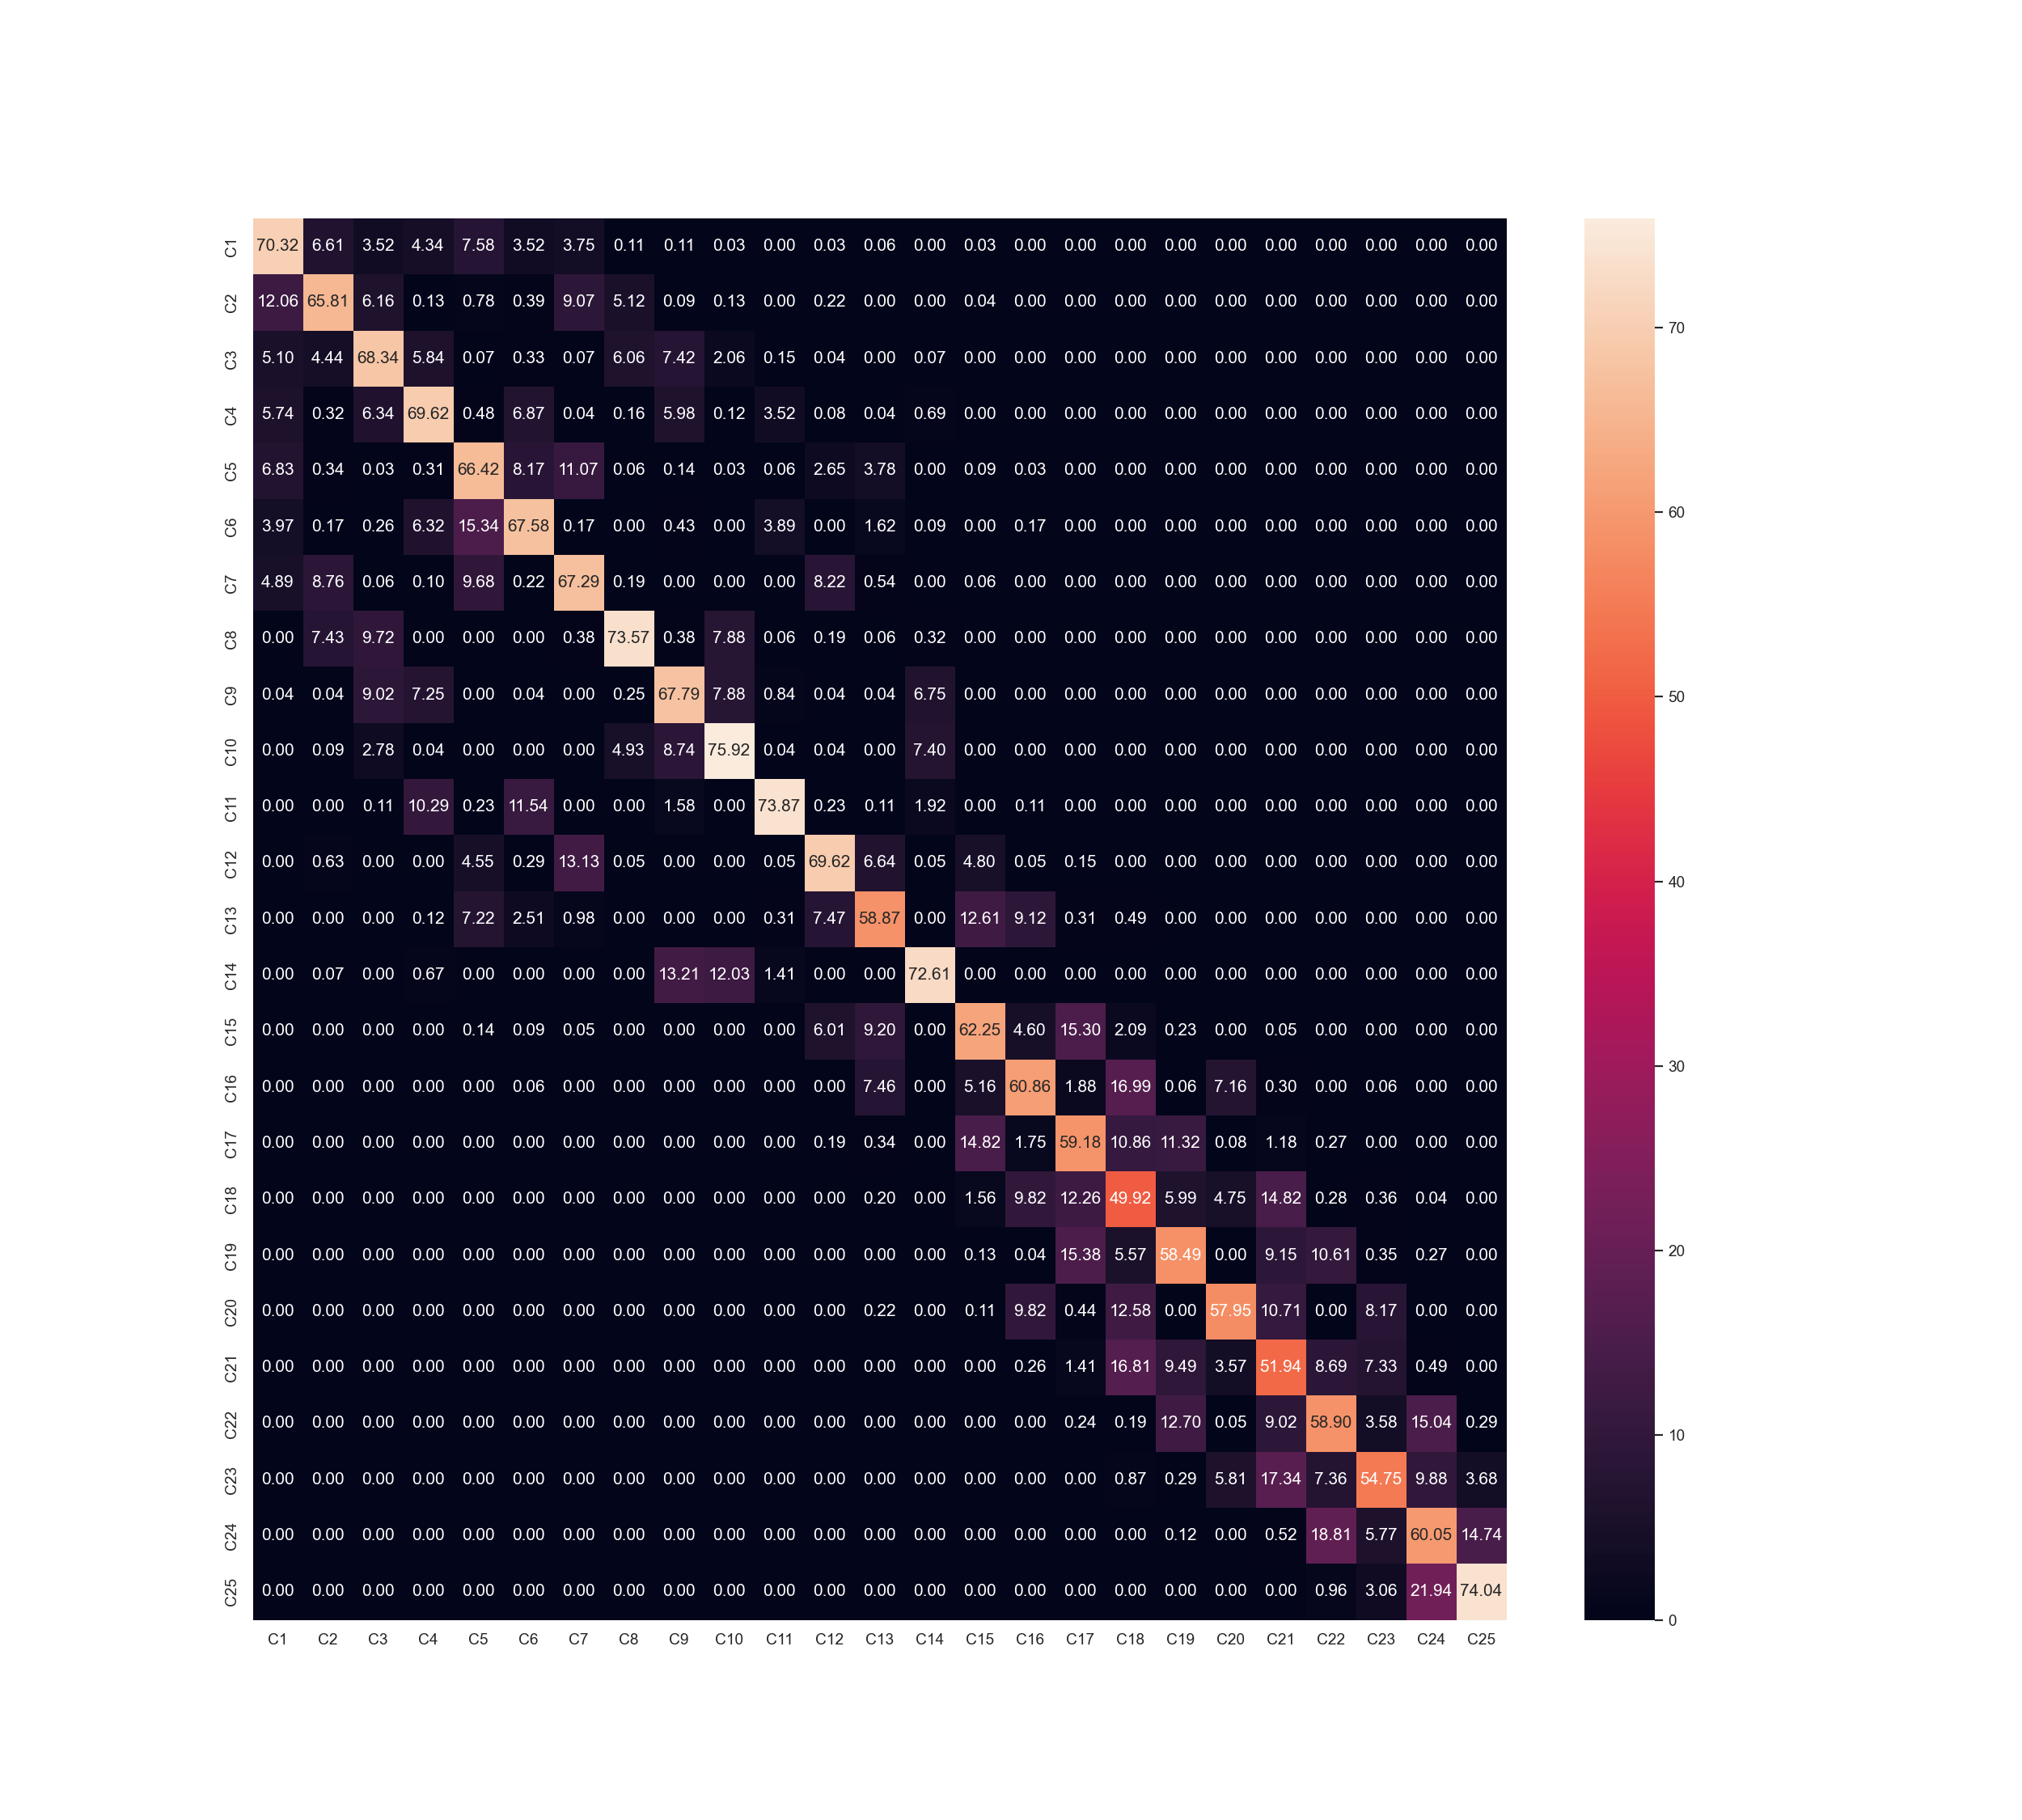

In [17]:
#SOLO FUNCIONA PARA FILAS PERO NO PARA COLUMNAS
plt.figure(figsize=(20,18))

ht =sns.heatmap(mprob, annot=True,fmt='.2f')
figure = ht.get_figure()    
figure.savefig('ht_prob.png', dpi=400)

In [18]:
dfclpw

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-01 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01 23:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 23:10:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 23:20:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 23:30:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
lsPath = 'C:/Users/mungu/Documents/DatosWTG.xlsx'
xlsPathMfgCurve = 'C:/Users/mungu/Dropbox/Doctorado/Python/aero/Curva de potencia vestas 90.xlsx'
dataVDP,dfVecVel,dfMfgCurve = myfunc.raw_to_datafr(lsPath,xlsPathMfgCurve)
dataVP = dataVDP.drop('Dir',axis=1)

Total de registros: 52848
Numero de filas sin datos
vViento    312
Pacw       312
dtype: int64


In [20]:

ncl = 25  # numero de clusters
nsubcl =0  #numero de subclusters
#subclusters
clsclord=('viento','potencia') #orden de clusterizado
# crear los dataframes agrupados en clusters
dfclvv, dfclpw, dfclvp, cl_ord,cl_cent,idx_centroids,scl_ord,scl_cent,idx_centroids_sc = myfunc.cluster2DataFrame(
    dfVecVel, dataVP, n_clusters=ncl,n_subclu =nsubcl,clusters=clsclord[0],subclusters=clsclord[1])



In [21]:
idx_centroids

,cluster_ID,PCTimeStamp,vx,vy,vViento,Pw
cluster_ID_ord,,,,,,
1,22,2016-03-26 04:20:00,-0.212890,0.452414,0.5,-1.272345e+04
2,1,2016-05-16 22:00:00,1.897891,-0.089502,1.9,0.000000e+00
3,9,2016-08-28 22:30:00,-1.626936,-1.898178,2.5,0.000000e+00
4,16,2016-06-14 05:50:00,0.944453,2.422397,2.6,-1.272345e+04
5,14,2016-08-12 23:30:00,-2.545132,0.901279,2.7,2.544690e+04
6,2,2016-06-12 00:10:00,-1.048898,2.596115,2.8,0.000000e+00
7,11,2016-03-31 19:20:00,0.731001,-2.806357,2.9,-1.272345e+04
8,12,2016-01-26 17:30:00,3.538324,-1.865547,4.0,6.361725e+04
9,6,2016-07-02 04:10:00,-4.666530,-2.512668,5.3,2.799159e+05


In [22]:
a = np.sqrt(idx_centroids.vx**2 +idx_centroids.vy**2)
idxc = idx_centroids.copy()
idxc['media'] = a
idxc

,cluster_ID,PCTimeStamp,vx,vy,vViento,Pw,media
cluster_ID_ord,,,,,,,
1,22,2016-03-26 04:20:00,-0.212890,0.452414,0.5,-1.272345e+04,0.5
2,1,2016-05-16 22:00:00,1.897891,-0.089502,1.9,0.000000e+00,1.9
3,9,2016-08-28 22:30:00,-1.626936,-1.898178,2.5,0.000000e+00,2.5
4,16,2016-06-14 05:50:00,0.944453,2.422397,2.6,-1.272345e+04,2.6
5,14,2016-08-12 23:30:00,-2.545132,0.901279,2.7,2.544690e+04,2.7
6,2,2016-06-12 00:10:00,-1.048898,2.596115,2.8,0.000000e+00,2.8
7,11,2016-03-31 19:20:00,0.731001,-2.806357,2.9,-1.272345e+04,2.9
8,12,2016-01-26 17:30:00,3.538324,-1.865547,4.0,6.361725e+04,4.0
9,6,2016-07-02 04:10:00,-4.666530,-2.512668,5.3,2.799159e+05,5.3


<IPython.core.display.Javascript object>


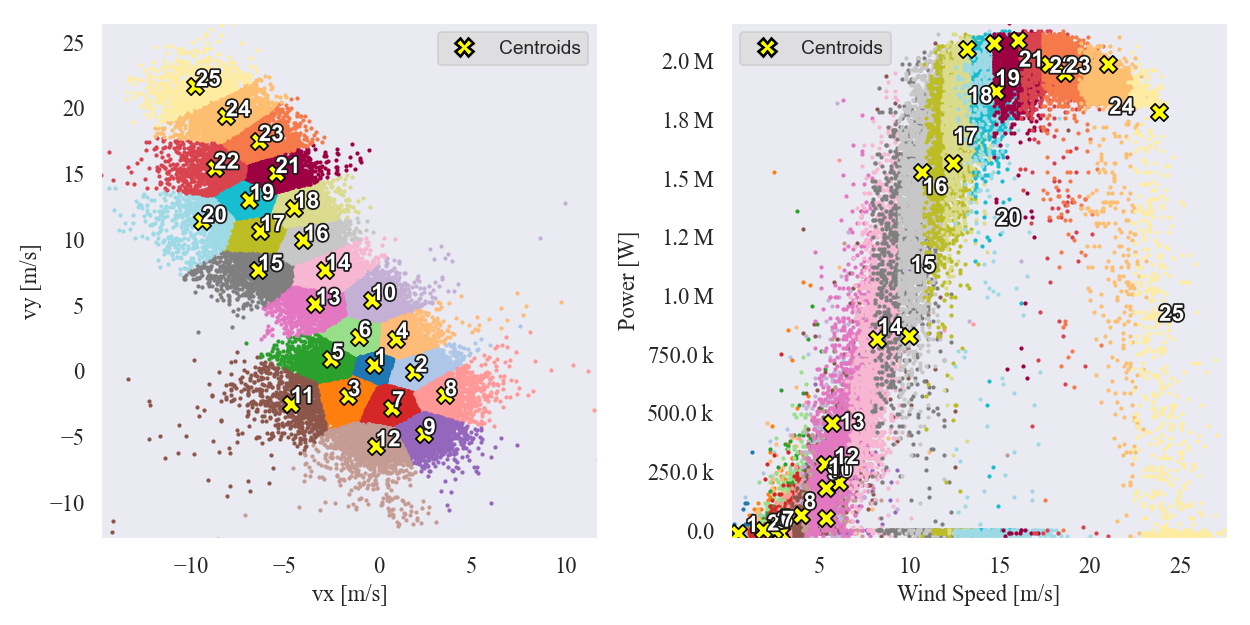

C:\Users\mungu\Documents\GitHub\transiciones\my_funcs_clusters.ipynb:673: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  "            self.axvp.plot(self.dfMfgCurve.index, self.dfMfgCurve.pw, c='red', label='Manufacturer')\n",


Saved in VVVPCl25SCl0_26-01-2022_11_26_56_967526.png
Saved in VVVPCl25SCl0_26-01-2022_11_28_31_107496.png
Saved in VVVPCl25SCl0_26-01-2022_11_28_50_499464.png
Saved in VVVPCl25SCl0_26-01-2022_11_29_07_735192.png


In [23]:

ploti = myfunc.plotSubClusterInt()
ploti.createPlot(dfclvv, dfclvp, dataVP, figsize=(
    10, 5), cl_scl_order=clsclord, idx_centroids=idx_centroids,idx_centroids_sc=idx_centroids_sc,fign=201,
                showlBetz=False,  showCent= True, showOpt= 'Magnitud', showMfgCurve=False,
                dfMfgCurve=dfMfgCurve)

<IPython.core.display.Javascript object>


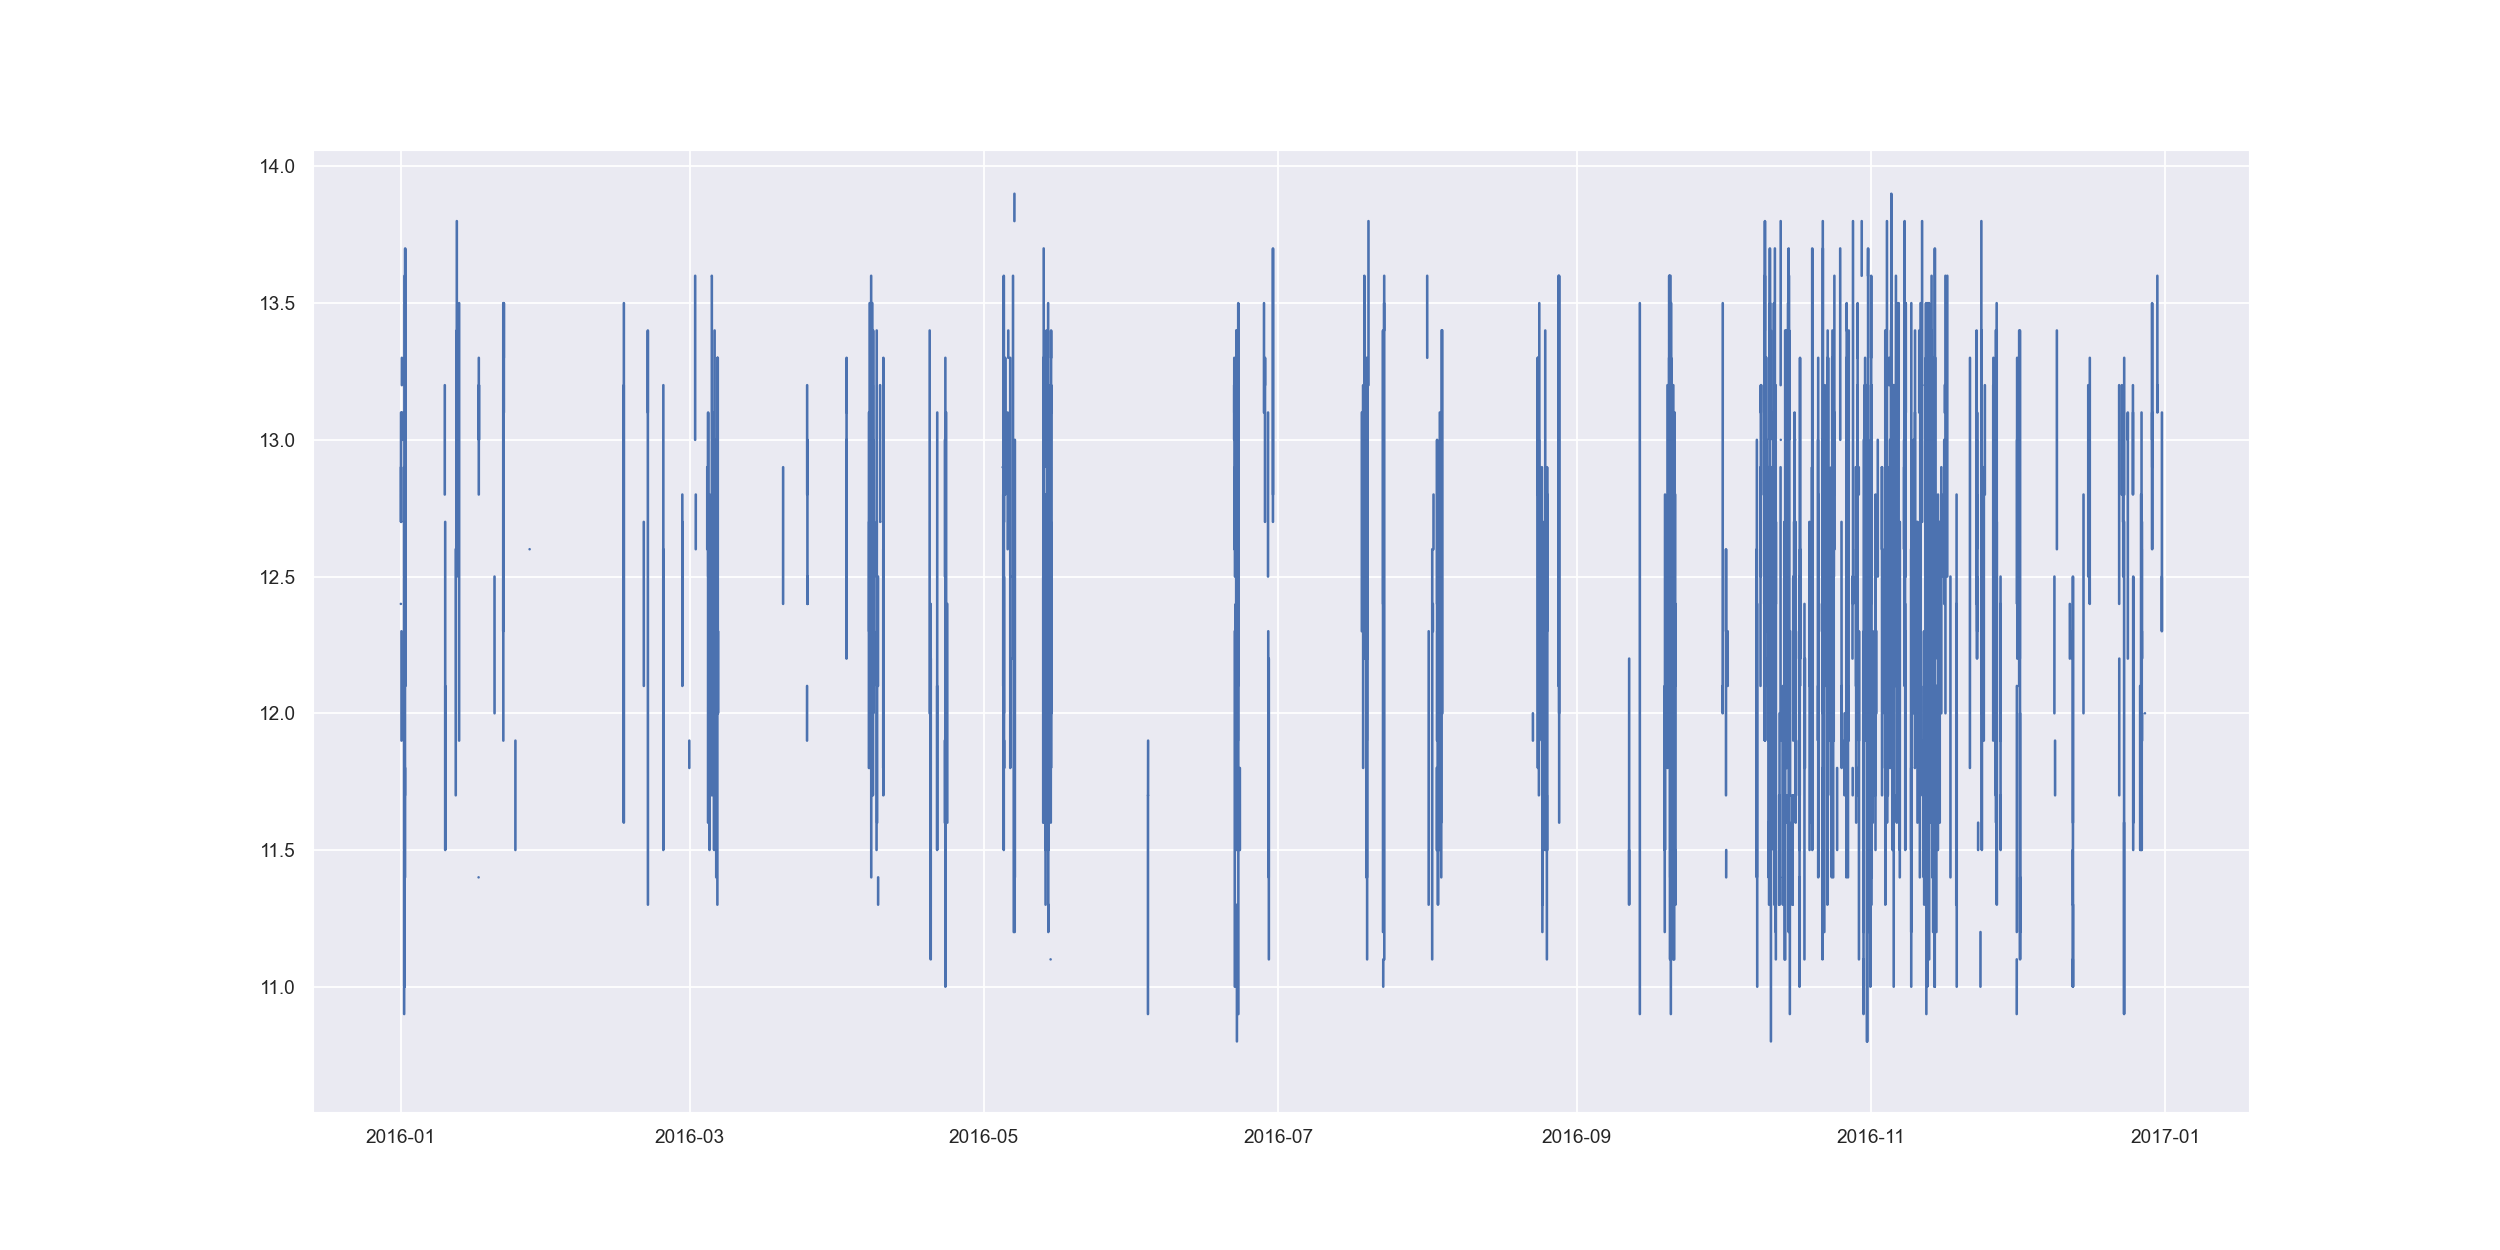

In [24]:
plt.figure(figsize=(20,10))
plt.plot(dfclvp.C17.index,dfclvp.C17.vViento)
plt.show()

## Tiempo total que pasa en estados de interes

In [25]:
dfclvp.C17.min()

vViento       10.700000
Pw        -38170.350741
dtype: float64

In [26]:
dfclvp.C17.max()

vViento    1.390000e+01
Pw         2.112093e+06
dtype: float64

In [27]:
vel_prom_estados = [8.2,10.7, 12.4]

## buscar transiciones

In [28]:
# 1.- encontrar el primer dato no NAN del estado (df ordenado cronologicamente)
# 2.- encontrar el siguiente dato NAN. El estado se encuentra entre estos dos no NAN y NAN
#

dfclvp.C17.first_valid_index()

Timestamp('2016-01-01 00:00:00')

In [29]:
dfclvp.C17.isnull()

,vViento,Pw
2016-01-01 00:00:00,False,False
2016-01-01 00:10:00,True,True
2016-01-01 00:20:00,True,True
2016-01-01 00:30:00,True,True
2016-01-01 00:40:00,True,True
...,...,...
2017-01-01 23:00:00,True,True
2017-01-01 23:10:00,True,True
2017-01-01 23:20:00,True,True
2017-01-01 23:30:00,True,True


In [30]:
#va a buscar renglon por renglon si el valor es nan y
#va a agrupar los valores que no son nan junto con su timestamp
num_estado = 'C17'
dfclvp[num_estado].first_valid_index() #primer valor que no es nan
lista=[]
C=[]
flag= True
for i in dfclvp[num_estado].itertuples():
    if not np.isnan(i[1]):
        C.append([i[0],i.vViento,i.Pw])
        flag = False
        
        
    if flag == False:    
        lista.append(C)
        C.clear()
        flag_nonan=True

In [31]:
def groupStateValues(statenum,dfclvp):
    '''
Agrupa los valores con datos diferentes a nan de un estado en particular. Los datos se agregan a una lista hasta
que salta a otro estado, con esto se puede saber cuanto tiempo duro en un estado.

    Inputs:
            statenum: numero de estado, empieza en 1
            dfclvp: dataframe con los clusters separados de vv y pw
    Outputs:
            lista_valores_estado: una lista con los valores del estado agrupados 
    '''
    #va a buscar renglon por renglon si el valor es nan y
    #va a agrupar los valores que no son nan junto con su timestamp
    statenum ='C'+str(statenum)
    idx =  dfclvp[statenum].first_valid_index() #primer indice que no tiene valores nan
    lista_valores_estado=[] #contiene los valores agrupados de tiempo vv y pw
    row_values=[]# lista temporal para agrupar los valores de tiempo vv y pw
    idxw=0 #indice exclusivo para el ciclo for
    while not idxw ==  dfclvp.index[-1]: #si el indice ya llego a la ultima fila

        for row in dfclvp[statenum][idx:].itertuples(): #empieza en el ultimo indice que no tuvo valores
            if not np.isnan(row.vViento):
                row_values.append([row[0],row.vViento,row.Pw])
            #si el valor es nan y row_values tiene elementos significa que
            #ya tomo todos los valores del estado y se brinco a otro
            if np.isnan(row.vViento) and len(row_values)>0:
                idx=row[0]
                lista_valores_estado.append(row_values.copy())
                row_values.clear()
                break
            idxw =row[0]#para saber cuando llega al ultimo indice
    return lista_valores_estado

In [32]:
c17agrupado = groupStateValues(17,dfclvp)

In [33]:
listaTiempos=[] #cuenta el numero de elementos que tiene cada lista
#es decir si la lista contiene 4 elementos, quiere decir que el estado 
#estuvo sin cambios 40 minutos
for i in c17agrupado:
    listaTiempos.append(len(i))
    

In [34]:
#moda de los tiempos por cada unidad son 10 minutos
stats.mode( listaTiempos)

ModeResult(mode=array([1]), count=array([626]))

In [35]:
#promedio de los tiempos de estadia, 1.95 es aprox 2 o 20 min
np.mean(listaTiempos)

1.956445993031359

In [36]:
tempdf= dfclvp.C17.copy()
tempdf.dropna(inplace=True)
tempdf.reset_index(inplace=True)
tempdf.rename(columns={'index':'timeStamp'},inplace=True)

In [37]:
#solo conservar las horas
l=tempdf['timeStamp'].dt.time.values
#calcular la moda, es decir, a que hora es más probable el estado
stats.mode(l)

ModeResult(mode=array([datetime.time(0, 40)], dtype=object), count=array([25]))

# Markov chain

<IPython.core.display.Javascript object>


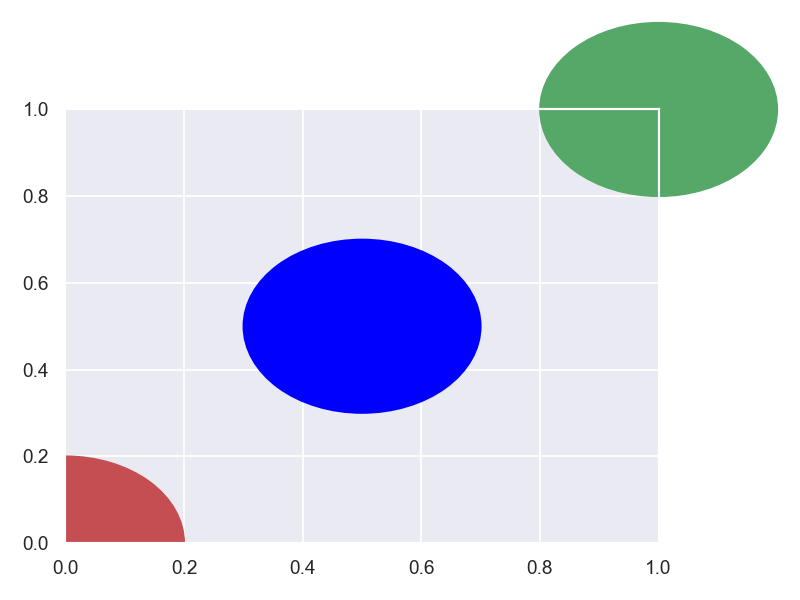

AttributeError: 'AxesSubplot' object has no attribute 're'

In [38]:
circle1 = plt.Circle((0, 0), 0.2, color='r')
circle2 = plt.Circle((0.5, 0.5), 0.2, color='blue')
circle3 = plt.Circle((1, 1), 0.2, color='g', clip_on=False)

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.re


##  Con cairo es mas dificil por que se usan coordenadas relativas, hay que estar calculando coordenadas a cada rato

In [ ]:
from io import BytesIO

import cairo
import IPython.display

svgio = BytesIO()
with cairo.SVGSurface(svgio, 200, 200) as surface:
    # These lines are copied verbatim from the
    # pycairo page: https://pycairo.readthedocs.io
    context = cairo.Context(surface)
    x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
    x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
    context.scale(200, 200)
    context.set_line_width(0.04)
    context.move_to(x, y)
    context.curve_to(x1, y1, x2, y2, x3, y3)
    context.stroke()
    context.set_source_rgba(1, 0.2, 0.2, 0.6)
    context.set_line_width(0.02)
    context.move_to(x, y)
    context.line_to(x1, y1)
    context.move_to(x2, y2)
    context.line_to(x3, y3)
    context.stroke()
    # end of pycairo copy
IPython.display.SVG(data=svgio.getvalue())

In [ ]:
from io import BytesIO
import math
import cairo
import IPython.display

num_circulos=25 #numero de circulos a dibujar
rad_circulos=20 #radio de los circulos a dibujar
sep_circulos = 3  *rad_circulos#separacion entre circulos, es n veces el radio
x_ini = rad_circulos*2 #donde inicia (el borde?) del circulo
y_ini = rad_circulos*2 
font_size= rad_circulos

svgio = BytesIO()
with cairo.SVGSurface(svgio, 1000, 1000) as surface:
    # These lines are copied verbatim from the
    # pycairo page: https://pycairo.readthedocs.io
    context = cairo.Context(surface)
    context.arc(x_ini,y_ini , rad_circulos, 0, 2*math.pi)
    for i in range(num_circulos-1):
        context.arc(x_ini+(sep_circulos*i),y_ini , rad_circulos, 0, 2*math.pi)
        # Drawing code
        context.set_font_size(font_size)
        context.select_font_face("Arial",
                     cairo.FONT_SLANT_NORMAL,
                     cairo.FONT_WEIGHT_NORMAL)
        context.move_to(x_ini+(sep_circulos*i)-font_size/2,y_ini+font_size/4)
        context.show_text(str(i))
        # End of drawing code
        context.stroke()

    
    
    
    # end of pycairo copy
IPython.display.SVG(data=svgio.getvalue())